## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Data Cleaning](#cleaning)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  
For this project, we are working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='cleaning'></a>
### Data Description and Cleaning

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Setting the seed to assure you get the same answers 
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

For how long was the experiment ran?

In [5]:
min(df['timestamp']), max(df['timestamp'])

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

- The experiment was ran for approximately 22 days.

The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- No missing values

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Therefore we'll drop these rows and store the new dataframe in **df2**.

In [9]:
df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index, axis=0, inplace=True)
df2 = df

#### Analyzing the new dataframe

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# Shape of the new dataframe
df2.shape

(290585, 5)

Unique **user_id**s in **df2**

In [12]:
df2['user_id'].nunique()

290584

Checking for duplicates: There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The user_id for the non-unique id in df2: 773192
The landing_page for the non-unique id: new_page
The group for the non-unique id: treatment
The value of converted column for the non-unique id: 0

Since, there is consistency with this non-unique id, we can just choose one and remove.

Removing **one** of the rows with a duplicate **user_id**, but keeping the dataframe as **df2**.

In [15]:
df2 = df2.drop(df2[df2.user_id.duplicated()].index)

In [16]:
# Check that duplicated user_id row was correctly removed
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


In [17]:
# Check the shape of the updated dataframe
df2.shape

(290584, 5)

<a id='probability'></a>
### Part I - Probability

Probability of an individual converting regardless of the page they receive

In [18]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

Probability that an individual received the new page

In [21]:
((df2[df2['landing_page'] == "new_page"]).count()['landing_page'])/df2.shape[0]

0.5000619442226688

- From the results above, there isn't sufficient evidence to conclude that the new page leads to more conversions, since the probability of converting in the control and treatment groups are about the same.

<a id='ab_test'></a>
### Part II - A/B Test

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses will be as follows:  

- Null Hypothesis: The old page is equally as good or even better than the new page. (**$p_{old}$** - **$p_{new}$** >= 0)
- Alternative Hypothesis: The new page is worse than the old page. (**$p_{old}$** - **$p_{new}$** < 0)

#### First Method

We'll assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we'll assume they are equal to the converted rate in ab_data.csv regardless of the page.

We'll use a sample size for each page equal to the ones in ab_data.csv, and we'll perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null  

What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

What is $n_{new}$?

In [24]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

What is $n_{old}$?

In [25]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

3.917220311787373e-05

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one calculated above and store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
p_diffs = []
for i in range(10000):
    new_page_c = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
    old_page_c = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
    p_diffs.append(new_page_c.mean() - old_page_c.mean())
    
p_diffs = np.array(p_diffs)

Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

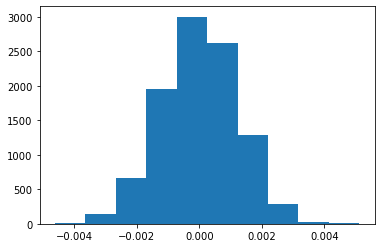

In [30]:
plt.hist(p_diffs);

- The plot results into a normal distribution, which is as expected due to the Central Limit Theorem.

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# Calculating the actual difference observed in df2
obs_diff = df2.query('group=="treatment"').converted.mean() - df2.query('group=="control"').converted.mean()
obs_diff

-0.0015782389853555567

In [32]:
(p_diffs > obs_diff).mean()

0.9034

- The value computed above is the p-value. the smaller it is the more stastically significant a variable is.
- From the calculation, the p-value is way above the 5% type 1 error rate, therefore we fail to reject the null hypothesis.
- Our conclusion then is, the old page conversion rate is equally as good or even better than the new page conversion rate.

#### Second Method

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

We need to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

# Calculating number of conversions per page
convert_old = sum((df2.group=='control')&(df2.converted==1))
convert_new = sum((df2.group=='treatment')&(df2.converted==1))

# Calculating number of individuals who received each page
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
count = [convert_new, convert_old]
nobs = [n_new, n_old]

z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative = 'larger') 
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in the first method?

- With a p-value above the Type I error rate of 5%, we fail to reject the null.
- We can conclude that the old page's conversion rate is equal or greater than the new page's.

This result agrees with the findings in the First Method of A/B Test performed before.

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br>
Since each row is either a conversion or no conversion, we'll perform a __Logistic Regression__.

#### We'll first use one variable to predict the conversion rate - the page a user receives

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  

However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# Adding an intercept column
df2['intercept'] = 1

# Creating dummy variables
df2[['ab_page', 'no_page']] = pd.get_dummies(df['landing_page'])

In [36]:
# We'll drop the 'no_page' column since we only need one column with dummy variables
df2.drop('no_page', axis=1, inplace=True)
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1


Using **statsmodels** to import our regression model, we'll instantiate the model, and fit the model using the two columns you created in above, to predict whether or not an individual converts.

In [37]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Instantiating the regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# Fitting the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of the model below

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        12:29:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.190. This p-value is associated with the following two-sided test:

$$H_0: \beta_{1} = 0$$$$H_1: \beta_{1} \neq 0$$
$\beta_{1}$ being the coefficient of ab_page in the Logistic Regression equation to predict conversion.

Since this p-value (0.190) is higher than 0.05, with a Type I error rate of 5%, we fail to reject the Null. Therefore, the page (old or new) a user sees is not statistically significant for predicting if a user converts or not.<br>
__This p-value is different from the one in Part II because they belong to different Hypothesis Testing.__ 

However, the conclusions in both are linked:
- In part II, we concluded that the old page conversion rate is equally as good or even better than the new page conversion rate.
- In this part, we conclude that the page does not change the conversion rate significantly.

#### Using more than one variable to predict the conversion rate 

Now, we are considering other things that might influence whether or not an individual converts.  

Discuss why it is __a good idea__ to consider other factors to add into your regression model.  
- As an advantage, addition of other factors might better predict whether an individual converts or not. This also helps in checking if the added variables are statistically or practically significant, and to obtain the best model for prediction.
- Also, adding more variables could help detect any Simpson's Paradox.

Are there any __disadvantages__ to adding additional terms into your regression model?
- However, due to factors like presence of multicollinearity between the added variables, the prediction might result into erroneous results.


Now along with testing if the conversion rate changes for different pages, we'll also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together our dataframe on the approporiate rows.  

In [39]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [40]:
# Adding the dummy variables for the country column
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1


As discussed above, we'll check for multicolinearity between the variables

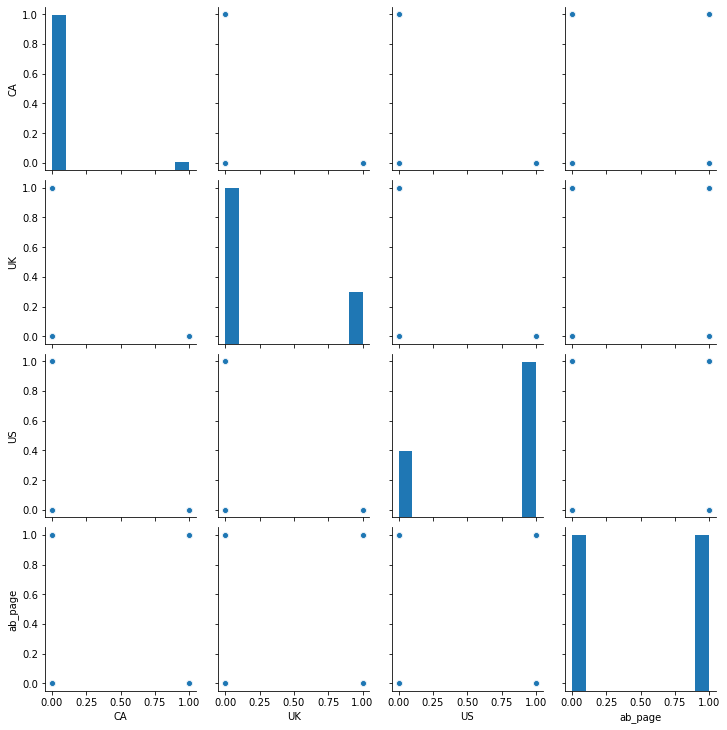

In [41]:
# Checking for multicollinearity using pairplot
import seaborn as sns

sns.pairplot(df_new[['CA', 'UK', 'US', 'ab_page']])

- It is evident that there is no multicolinearity between the variables.

In [42]:
# Checking for multicollinearity using VIF, with CA as our baseline
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('converted ~ ab_page + UK + US', df_new, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif

,VIF Factor,features
0,21.055923,Intercept
1,1.000006,ab_page
2,4.502236,UK
3,4.502223,US


- The vif factors for all the explanatory variables are below 5, which means they have no multicollinearity.

Now let's fit our model.

In [43]:
# Instantiating the model
logit_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])

# Fitting the model
results = logit_mod2.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        12:29:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

Does it appear that country had an impact on conversion? 

- With the p-values for all the independent variables (ab_page, UK and US) being higher than 0.05, with a Type I error rate of 5%, neither of them is statistically significant for predicting if a user converts or not. 
- Therefore, neither the page a user sees (old or new) or their country have an impact in predicting if a user converts or not.

#### Using more than one variable, and an Interaction to predict the conversion rate.

Though we have now looked at the individual factors of country and page on conversion, we would like to look at an interaction between page and country to see if there significant effects on conversion.

In [44]:
# Creating the interactions
df_new['ab_page_US'] = df_new['ab_page'] * df_new['UK']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['US']

In [45]:
# Instantiantiating the model and adding the new columns
logit_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'ab_page_UK', 'ab_page_US']])

# Fitting the model
results = logit_mod3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 13 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        12:29:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page_UK     0.0469      0.054      0.872      0.383      -0.059       0.152
ab_page_US     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

- With the p-values for all the independent variables (ab_page, UK and US) and for the interactions as well, being higher than 0.05, with a Type I error rate of 5%, neither of them is statistically significant for predicting if a user converts or not. 
- Therefore, neither the page a user sees (old or new) or their country have an impact in predicting if a user converts or not.

<a id='conclusions'></a>
### Conclusions

The overall conclusions of this project are the following:

- There are a total of 290,584 unique users who participated in the experiment. 12% of them converted, regardless of the page they received.
- These participants had an equal probability of getting either the old or new page.
- With a Type I error rate of 5%, we failed to reject the null hypothesis, thus the old page's conversion rate is equal or greater than the new page's, so we do not advice to change the page based only on expecting a higher conversion rate.
- The page each user received (old or new) is not statistically significant in predicting whether or not an individual converts.
